Nous présentons ici 3 algorithmes de Bandit stochastiques.

Ils nous ont servi à appréhender et de comprendre quelques premières notions et enjeux du reinforcement learning. Ci-dessous 3 versions différentes du Bandit stochastique sont disponibles, selon la policy implémentées :
1. Random stochastic bandit
2. Epsilon stochastic bandit (2 déclinaisons)
3. Upper Condident Bound (UCB) stochastic bandit 
4. Comparaison des 3 algorithmes
5. Etude sensibilité des hyper paramètres

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Random stochastic bandit

Ici, pas de recherche du bras qui maximiserait le reward : à chaque itération, on choisit le bras de manière aléatoire.

In [2]:
def stochastic_bandit_random(arms, T_max, sigma):
    
    K = len(arms) # nombre de bras
    estimation = [0]*K # on fixe les estimations pour les bras à 0 (pas d'info)
    
    for i in range(K):
        estimation[i] = np.random.normal(arms[i], sigma) # on tire 1 fois chaque bras (initialisation)
        
    N = [1]*K # mise à jour du nombre d'activation de chaque bras 
    R = [0] # regret global initialisé à 0
    best = np.max(arms) # meilleur bras
    
    for t in range(T_max): # main loop
        
        pull_i = np.random.randint(K) # on tire un bras de manière aléatoire
        
        reward = np.random.normal(arms[pull_i], sigma) # récuperation de la récompense 
        estimation[pull_i] = (estimation[pull_i]*N[pull_i] + reward)/(N[pull_i]+1) # mise à jour de l'estimation pour le bras tiré
        
        N[pull_i] += 1 # mise à jour du nombre d'activation
        R.append(R[-1] + (best - arms[pull_i])) # mise à jour du regret
        
    return R, (np.argmax(arms) == np.argmax(estimation))

Is the answer correct ?  True
Regret final : 19798


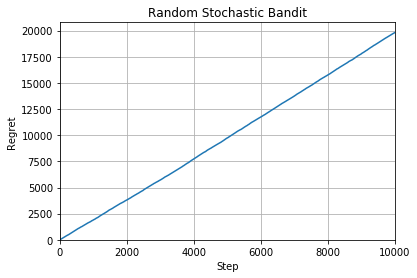

In [3]:
arms  = [1, 2, 3, 4, 5] # liste des means des bras
T_max = 10000 # temps max
sigma = 0.5 # écart-type

R_random, success = stochastic_bandit_random(arms, T_max, sigma)
print("Is the answer correct ? ",success)
print("Regret final :",R_random[-1])

plt.plot(R_random)
plt.xlim(0,T_max)
plt.xlabel("Step")
plt.ylabel("Regret")
plt.title("Random Stochastic Bandit")
plt.ylim(0)
plt.grid()
plt.show()

La mise en évidence d'une évolution du regret linéaire signifie que l'algorithme n'apprend pas à identifier le meilleur bras. Ici, rien de surprenant avec une policy random.

On peut utiliser l'inégalité d'Hoeffding pour avoir des bornes sur le regret :

$ \mathbb P (|\frac{1}{T_{max}}R(T_{max}) -  \frac{1}{n_{arms}} \sum_{i = 1}^{n_{arms}} (\mu^* - \mu_i)| > \epsilon) \le 2exp(-2T_{max}\epsilon^2) $

Ici $\frac{1}{n_{arms}} \sum_{i = 1}^{n_{arms}} (\mu^* - \mu_i) = \frac{1}{5}(0+1+2+3+4) = 2$ 

On a : $\mathbb E[R(T_{max})] = O(T_{max})$



In [4]:
mean_regret = R_random[-1]/T_max
epsilon = np.abs(2 - mean_regret)
print('Borne sup regret :', round(2*np.exp(-2*T_max*epsilon**2),2))

Borne sup regret : 0.0


## 2. $\epsilon$-greedy stochastic bandit

Compromis entre l'exploitation d'un bras pour maximiser le reward et l'exploration pour potentiellement en détecter un d'encore meilleur (qui engendrerait un reward encore plus grand). $\epsilon$ définit la limite entre l'exploitation/exploration et peut être implémenté de plusieurs manières (ici, différentes dépendances temporelles en $\dfrac{1}{t}$ et $\dfrac{1}{\sqrt t}$ implémentées).   

Pour illustrer l'idée, prenons le cas d'un $\epsilon$ constant = 0,9. Cela signifie que 90% du temps, nous allons tirer le bras qui génère, à notre connaissance, le plus de reward. Et 10% du temps, nous allons explorer les autres bras pour possiblement découvrir un bras générant un meilleur reward. En mode exploration, on tire au hasard un des bras. 

In [5]:
def stochastic_bandit_greedy(arms, T_max, sigma, alpha, root=False):
    
    K = len(arms) # nombre de bras
    estimation = [0]*K # on fixe les estimations pour les bras à 0 (pas d'info)
    
    for i in range(K):
        estimation[i] = np.random.normal(arms[i], sigma) # on tire 1 fois chaque bras (initialisation)
        
    N = [1]*K # mise à jour du nombre d'activation de chaque bras 
    R = [0] # regret global initialisé à 0
    best = np.max(arms) # meilleur bras
    
    for t in range(T_max):
    
        if root: # choix du epsilon 
            epsilon = alpha/np.sqrt(t + 1) 
        else:
            epsilon = alpha/(t + 1)
                   
        greed_factor = np.random.rand() # random sample from a uniform distribution over [0, 1]    
        if greed_factor < epsilon:
            pull_i = np.random.randint(K) # exploration : on tire un bras au hasard
        else: 
            pull_i = np.argmax(estimation) # exploitation 
            
        reward = np.random.normal(arms[pull_i], sigma) # récuperation de la récompense  
        estimation[pull_i] = (estimation[pull_i]*N[pull_i] + reward)/(N[pull_i]+1) # mise à jour de l'estimation
        
        N[pull_i] += 1 # mise à jour du nombre d'activation
        R.append(R[-1] + (best - arms[pull_i])) # mise à jour du regret
        
    return R, (np.argmax(arms) == np.argmax(estimation))

On prends $\alpha = \sqrt{2\log(T_{max})}$

Is the answer correct ?  True
Regret final : 1.8568103234850897


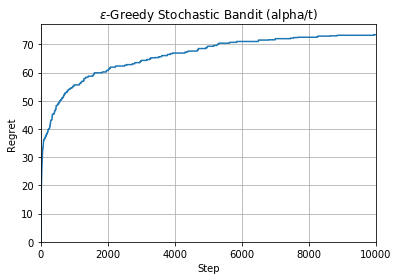

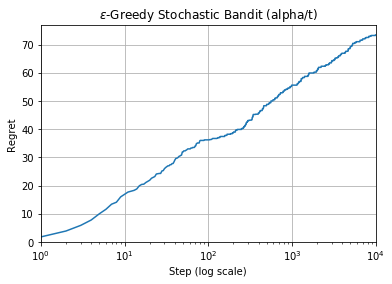

In [6]:
# Epsilon / t
arms  = [1,2,3,4,5]
T_max = 10000
sigma = 1
alpha = np.sqrt(2*np.log(T_max))

# On moyenne les résultats
R_eps1 = [0]*T_max
for _ in range(10):
    R_r, success = stochastic_bandit_greedy(arms, T_max, sigma, alpha)
    for i in range(T_max): 
        R_eps1[i] += R_r[i]
for i in range(T_max):
    R_eps1[i] /= 10
        

print("Is the answer correct ? ",success)
print("Regret final :",R_eps1[-1]/(alpha*np.log(T_max)))

plt.plot(R_eps1)
plt.xlim(0,T_max)
plt.xlabel("Step")
plt.ylabel("Regret")
plt.title(r"$\epsilon$-Greedy Stochastic Bandit (alpha/t)")
plt.ylim(0)
plt.grid()
plt.show()

plt.plot(R_eps1)
plt.xlim(1,T_max)
plt.xscale("log")
plt.xlabel("Step (log scale)")
plt.ylabel("Regret")
plt.title(r"$\epsilon$-Greedy Stochastic Bandit (alpha/t)")
plt.ylim(0)
plt.grid()
plt.show()

On obtient des courbes de regret classiques. Le regret croit beaucoup au départ puisque l'algorithme exploite souvent un mauvais bras. L'exploration lui permet de corriger le tir et de choisir à terme le bras le plus rentable en mode exploitation.

On utilise l'inéquation d'Hoeffding :

$ \mathbb P (  \frac{1}{T_{max}}\mathbb E[R(T_{max})] - \frac{1}{T_{max}}R(T_{max})  > \epsilon) \le 2exp(-2T_{max}\epsilon^2) $

$ \mathbb P (  (\frac{1}{T_{max}}\sum_{t=1}^{T_{max}} \frac{\alpha}{t})(\frac{1}{n_{arms}} \sum_{i = 1}^{n_{arms}} (\mu^* - \mu_i)) - \frac{1}{T_{max}}R(T_{max})  > \epsilon) \le 2exp(-2T_{max}\epsilon^2) $

Or $\sum_{t=1}^{T_{max}}\frac{\alpha}{t} = \alpha(log(T_{max}) + \gamma + o(1)) \sim \alpha log(T_{max})$ and $(\frac{1}{n_{arms}} \sum_{i = 1}^{n_{arms}} (\mu^* - \mu_i)) =2$

Finalement $\mathbb E[R(T_{max})] = O(\alpha log(T_{max})) = O(log(T_{max})^{\frac{3}{2}})$ avec la valeur de $\alpha = \sqrt{2log(T_{max})}$


Is the answer correct ?  True
Regret final : 42.39548257668476


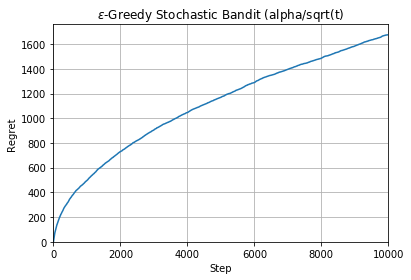

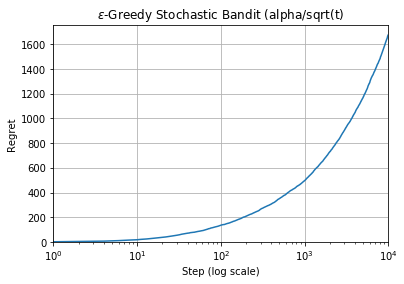

In [7]:
# Epsilon / sqrt(t)
arms  = [1,2,3,4,5]
T_max = 10000
sigma = 1
alpha = np.sqrt(2*np.log(T_max))

R_eps2 = [0]*T_max
for _ in range(10):
    R_r, success = stochastic_bandit_greedy(arms, T_max, sigma, alpha, True)
    for i in range(T_max): 
        R_eps2[i] += R_r[i]
for i in range(T_max):
    R_eps2[i] /= 10
        

print("Is the answer correct ? ",success)
print("Regret final :",R_eps2[-1]/(alpha*np.log(T_max)))

plt.plot(R_eps2)
plt.xlim(0,T_max)
plt.xlabel("Step")
plt.ylabel("Regret")
plt.title(r"$\epsilon$-Greedy Stochastic Bandit (alpha/sqrt(t)")
plt.ylim(0)
plt.grid()
plt.show()

plt.plot(R_eps2)
plt.xlim(1,T_max)
plt.xscale("log")
plt.xlabel("Step (log scale)")
plt.ylabel("Regret")
plt.title(r"$\epsilon$-Greedy Stochastic Bandit (alpha/sqrt(t)")
plt.ylim(0)
plt.grid()
plt.show()

$\epsilon$ décroit moins vite avec t que dans le cas précédent. La part laissée à l'exploration est donc plus importante et l'algorithme finit par fréquemment tirer un bras au hasard et donc gagner du regret (par rapport à l'exploitation pure). 

On utilise l'inéquation d'Hoeffding :

$ \mathbb P (  \frac{1}{T_{max}}\mathbb E[R(T_{max})] - \frac{1}{T_{max}}R(T_{max})  > \epsilon) \le 2exp(-2T_{max}\epsilon^2) $

$ \mathbb P (  (\frac{1}{T_{max}}\sum_{t=1}^{\sqrt{T_{max}}} \frac{\alpha}{t})(\frac{1}{n_{arms}} \sum_{i = 1}^{n_{arms}} (\mu^* - \mu_i)) - \frac{1}{T_{max}}R(T_{max})  > \epsilon) \le 2exp(-2T_{max}\epsilon^2) $

Or $\sum_{t=1}^{T_{max}}\frac{\alpha}{\sqrt{T_{max}}} \sim \alpha(2\sqrt{T_{max}})$.

Finalement $\mathbb E[R(T_{max})] = O(\alpha \sqrt{T_{max}}) = O(log(T_{max})\times \sqrt{T_{max}})$ avec la valeur de $\alpha = \sqrt{2log(T_{max})}$


## 3. Upper Confidence Bound (UCB) Stochastic Bandit

On peut résumer la philosophie de l'algorithme UCB en disant que l'on veut rester : "optimiste face à l'incertitude". On va donc systématiquement tirer le bras sur lequel on a le plus d'incertitude sur le reward qu'il pourrait accorder. Concrétement, on tire le bras qui a la : [valeur moyenne (inconnue) + intervalle de confiance] le plus elevé :

Soit il s'avère que c'est un très bon bras, et dans ce cas, on a bien fait de le tirer. Soit c'est un mauvais bras et on saura qu'il n'est pas nécessaire de continuer à l'explorer à l'avenir. 

Au fur et à mesure, on tendra à réduire l'incertitude sur les bras et à identifier celui qui fournit le plus de reward (ou le moins de regret). 

In [8]:
def stochastic_bandit_UCB(arms, T_max, sigma, alpha):
    
    K = len(arms) # nombre de bras
    estimation = [0]*K # on fixe les estimations pour les bras à 0 (pas d'info)
    
    for i in range(K):
        estimation[i] = np.random.normal(arms[i], sigma) # on tire 1 fois chaque bras (initialisation)
        
    N = [1]*K # mise à jour du nombre d'activation de chaque bras 
    R = [0] # regret global initialisé à 0
    best = np.max(arms) # meilleur bras
    
    for t in range(T_max):
        
        pull_i = np.argmax([estimation[i] + alpha/np.sqrt(N[i]) for i in range(K)]) # on tire le bras avec l'incertitude la plus grande sur l'estimation de son reward
        
        reward = np.random.normal(arms[pull_i], sigma) # récuperation de la récompense (mean + dispersion gaussienne)      
        estimation[pull_i] = (estimation[pull_i]*N[pull_i] + reward)/(N[pull_i]+1) # mise à jour de l'estimation
        
        N[pull_i] += 1 # mise à jour du nombre d'activation
        R.append(R[-1] + (best - arms[pull_i])) # mise à jour du regret
        
    return R,(np.argmax(arms) == np.argmax(estimation))

Is the answer correct ?  True
Regret final : 0.07455849628554498


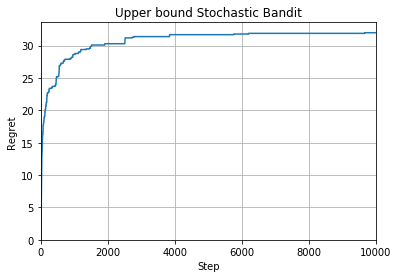

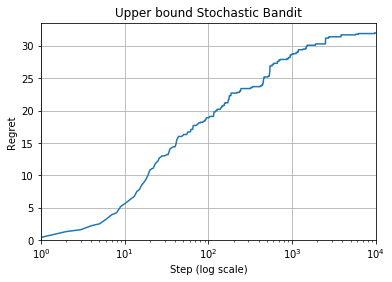

In [9]:
arms  = [1,2,3,4,5]
T_max = 10000
sigma = 1
alpha = np.sqrt(2*np.log(T_max))

R_UCB1 = [0]*T_max
for _ in range(10):
    R_r, success = stochastic_bandit_UCB(arms, T_max, sigma, alpha)
    for i in range(T_max):
        R_UCB1[i] += R_r[i]

for i in range(T_max):
    R_UCB1[i] /= 10
    
print("Is the answer correct ? ",success)
print("Regret final :",R_UCB1[-1]/(alpha*np.sqrt(T_max)))

plt.plot(R_UCB1)
plt.xlim(0,T_max)
plt.xlabel("Step")
plt.ylabel("Regret")
plt.title(r"Upper bound Stochastic Bandit")
plt.ylim(0)
plt.grid()
plt.show()

plt.plot(R_UCB1)
plt.xlim(1,T_max)
plt.xscale('log')
plt.xlabel("Step (log scale)")
plt.ylabel("Regret")
plt.title(r"Upper bound Stochastic Bandit")
plt.ylim(0)
plt.grid()
plt.show()

On converge le plus rapidement vers le bras optimal avec UCB. 

## Comparaison des algorithmes

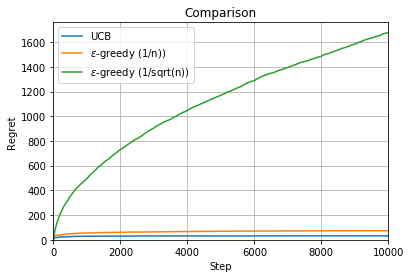

In [10]:
#plt.plot(R_random,label="random")
plt.plot(R_UCB1,label="UCB")
plt.plot(R_eps1,label=r"$\epsilon$-greedy (1/n))")
plt.plot(R_eps2,label=r"$\epsilon$-greedy (1/sqrt(n))")

plt.xlim(0,T_max)
plt.xlabel("Step")
plt.ylabel("Regret")
plt.title(r"Comparison")
plt.ylim(0)
plt.legend()
plt.grid()
plt.show()

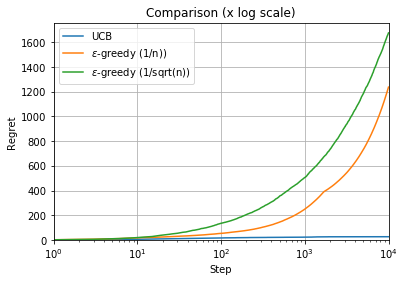

In [11]:
#plt.plot(R_random,label="random")
plt.plot(R_UCB1,label="UCB")
plt.plot(R_eps1,label=r"$\epsilon$-greedy (1/n))")
plt.plot(R_eps2,label=r"$\epsilon$-greedy (1/sqrt(n))")

plt.xlim(1,T_max)
plt.xscale('log')
plt.xlabel("Step")
plt.ylabel("Regret")
plt.title(r"Comparison (x log scale)")
plt.ylim(0)
plt.legend()
plt.grid()
plt.show()

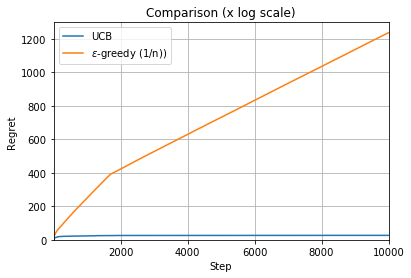

In [12]:
#plt.plot(R_random,label="random")
plt.plot(R_UCB1,label="UCB")
plt.plot(R_eps1,label=r"$\epsilon$-greedy (1/n))")
#plt.plot(R_eps2,label=r"$\epsilon$-greedy (1/sqrt(n))")

plt.xlim(1,T_max)
#plt.xscale('log')
plt.xlabel("Step")
plt.ylabel("Regret")
plt.title(r"Comparison (x log scale)")
plt.ylim(0)
plt.legend()
plt.grid()
plt.show()

On remarque que le regret généré par UCB est bien inférieur à $\epsilon$-greedy. C'est pourquoi la suite de l'étude sera d'utiliser la version linéarisée de cette algotithme et de l'appliquer à la recommandation de films ou d'articles de presse. 

# 4. Etude de sensibilité des hyper paramètres (UCB)

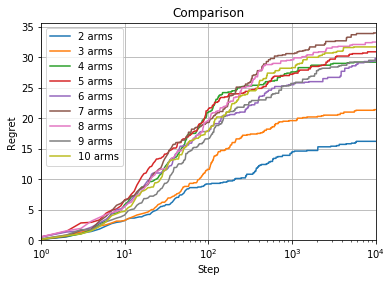

In [13]:
# Sensibilité nombre de bras
select_arms = [2, 3, 4, 5, 6, 7, 8, 9, 10]
arms  = [k+1 for k in range(np.max(select_arms))]
T_max = 10000
sigma = 1
alpha = np.sqrt(2*np.log(T_max))

R_UCB1_sensi = [[0] * T_max for i in range(len(arms))]
R_temp = [0]*T_max
for i in range(len(select_arms)):
    for _ in range(10):
        R_temp, sucess = stochastic_bandit_UCB(arms[:select_arms[i]], T_max, sigma, alpha)
        for j in range(T_max):
            R_UCB1_sensi[i][j] += R_temp[j]
            
    for k in range(T_max):
        R_UCB1_sensi[i][k] /= 10

    plt.plot(R_UCB1_sensi[i], label='%s arms' % select_arms[i])

plt.xlim(1,T_max)
plt.xscale('log')
plt.xlabel("Step")
plt.ylabel("Regret")
plt.title(r"Comparison")
plt.ylim(0)
plt.legend()
plt.grid()
plt.show()

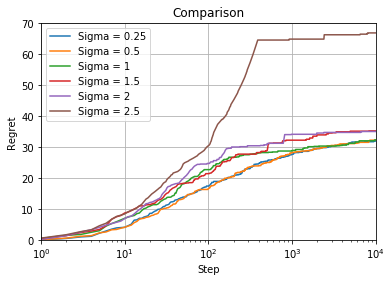

In [14]:
# Sensibilité écart-type
arms  = [1, 2, 3, 4, 5]
T_max = 10000
sigma = [0.25, 0.5, 1, 1.5, 2, 2.5]
alpha = np.sqrt(2*np.log(T_max))

R_UCB1_sensi_2 = [[0] * T_max for i in range(len(sigma))]
R_temp = [0]*T_max
for i in range(len(sigma)):
    for _ in range(10):
        R_temp, sucess = stochastic_bandit_UCB(arms, T_max, sigma[i], alpha)
        for j in range(T_max):
            R_UCB1_sensi_2[i][j] += R_temp[j]
            
    for k in range(T_max):
        R_UCB1_sensi_2[i][k] /= 10

    plt.plot(R_UCB1_sensi_2[i], label='Sigma = %s' % sigma[i])

plt.xlim(1,T_max)
plt.xscale('log')
plt.xlabel("Step")
plt.ylabel("Regret")
plt.title(r"Comparison")
plt.ylim(0)
plt.legend()
plt.grid()
plt.show()